In [1]:
%load_ext autoreload
%autoreload 2                                                                                                                          

In [2]:
import configparser
import os.path
from os import path
from importlib import reload
import wandb


creds_path_ar = ["../../credentials.ini","credentials.colab.ini"]
PATH_ROOT = ""
PATH_DATA = ""

for creds_path in creds_path_ar:
    if path.exists(creds_path):
        config_parser = configparser.ConfigParser()
        config_parser.read(creds_path)
        PATH_ROOT = config_parser['MAIN']["PATH_ROOT"]
        PATH_DATA = config_parser['MAIN']["PATH_DATA"]
        WANDB_enable = config_parser['MAIN']["WANDB_ENABLE"] == 'TRUE'
        ENV = config_parser['MAIN']["ENV"]
        break

if ENV=="COLAB":
  from google.colab import drive
  mount_path = '/content/gdrive/'
  drive.mount(mount_path)



In [3]:
if WANDB_enable == True:
    wandb.init(project="sota-mafat-base")
    os.environ['WANDB_NOTEBOOK_NAME'] = '[SS]TCN_pytorch'

In [4]:
cd {PATH_ROOT}

/home/shaul/workspace/GitHub/sota-mafat-radar


In [5]:
import os
import random
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim


from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score
from matplotlib.colors import LinearSegmentedColormap
from termcolor import colored

from src.data import feat_data, get_data, get_data_pipeline
from src.models import arch_setup, base_base_model, alex_model, tcn_model, tcn_model2

# Set seed for reproducibility of results
seed_value = 0
os.environ['PYTHONHASHSEED']=str(seed_value)


random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(0)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu:0')

In [6]:
config = dict()
config['num_tracks'] = 4
config['val_ratio'] = 6
config['shift_segment'] = list(np.floor(np.linspace(1,31,10)).astype(int))
config['get_shifts'] = False
config['get_horizontal_flip'] = False
config['get_vertical_flip'] = False

In [14]:
import importlib
importlib.reload(get_data_pipeline)

<module 'src.data.get_data_pipeline' from '/home/shaul/workspace/GitHub/sota-mafat-radar/src/data/get_data_pipeline.py'>

In [15]:
train_x, train_y, val_x, val_y = get_data_pipeline.pipeline_trainval(PATH_DATA, config)

In [25]:
train_set = arch_setup.DS(train_x,train_y)
val_set= arch_setup.DS(val_x,val_y)

train_loader=DataLoader(dataset= train_set, batch_size = 64, shuffle = True, num_workers = 2)
val_loader=DataLoader(dataset= val_set, batch_size = 64, shuffle = True, num_workers = 2)

In [171]:
importlib.reload(tcn_model3)

<module 'src.models.tcn_model3' from '/home/shaul/workspace/GitHub/sota-mafat-radar/src/models/tcn_model3.py'>

In [172]:
model = tcn_model3.TemporalConvNet(num_inputs = 1, num_channels = [16,32], kernel_size=5, dropout=0.2)
# model = tcn_model3.TestTCN(num_inputs = 1, num_channels = [16], kernel_size = 5)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), betas=(0.9, 0.999), lr=1e-3, weight_decay=0)

model.to(device);

# if WANDB_enable == True:
#     wandb.init(project="sota-mafat-tcn")
#     os.environ['WANDB_NOTEBOOK_NAME'] = '[SS]TCN_pytorch'
#     wandb.watch(model)
#     wandb.log(config)
#     wandb.config['num_channels'] = "[16,32,64,128]"
#     wandb.config['kernel_size'] = 5
#     wandb.config['dropout'] = 0.2

In [174]:
log = arch_setup.train_epochs(train_loader,val_loader,model,criterion,optimizer,num_epochs= 15,device=device,train_y=train_y,val_y=val_y, WANDB_enable = WANDB_enable, wandb= wandb)

100%|██████████| 29/29 [03:55<00:00,  8.12s/it]epoch : 1.0000, loss : 0.0101, auc : 0.6717, acc : 0.6222, val_loss : 0.0059, val_auc : 0.8910, val_acc : 0.8939, 
---------------------------

started training epoch no. 2

100%|██████████| 29/29 [04:06<00:00,  8.51s/it]epoch : 2.0000, loss : 0.0090, auc : 0.7762, acc : 0.7057, val_loss : 0.0030, val_auc : 0.9062, val_acc : 0.9678, 
---------------------------

started training epoch no. 3

100%|██████████| 29/29 [04:19<00:00,  8.94s/it]epoch : 3.0000, loss : 0.0083, auc : 0.8167, acc : 0.7453, val_loss : 0.0019, val_auc : 0.9319, val_acc : 0.9684, 
---------------------------

started training epoch no. 4

100%|██████████| 29/29 [04:16<00:00,  8.85s/it]epoch : 4.0000, loss : 0.0082, auc : 0.8219, acc : 0.7539, val_loss : 0.0051, val_auc : 0.9235, val_acc : 0.9233, 
---------------------------

started training epoch no. 5

100%|██████████| 29/29 [03:52<00:00,  8.01s/it]epoch : 5.0000, loss : 0.0080, auc : 0.8367, acc : 0.7686, val_loss :

  0%|          | 0/29 [1:13:06<?, ?it/s]


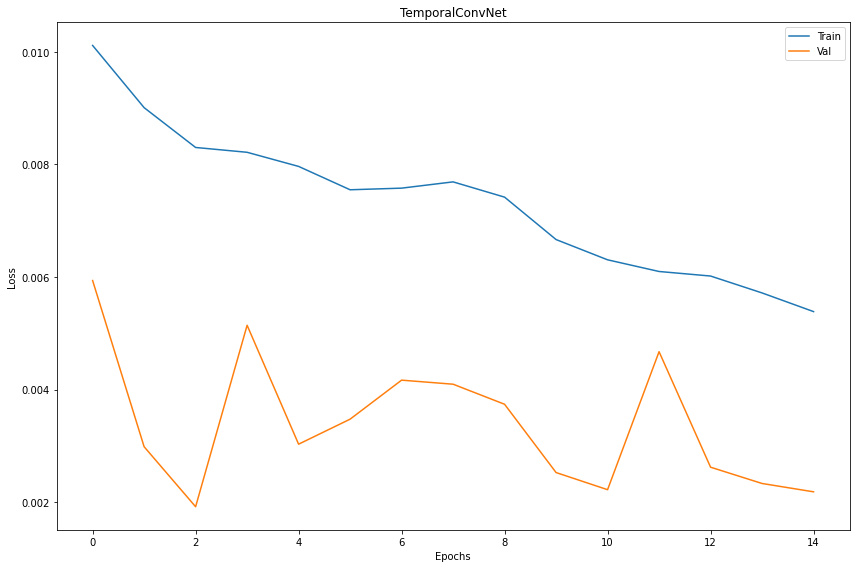

In [175]:
arch_setup.plot_loss_train_test(log,model)

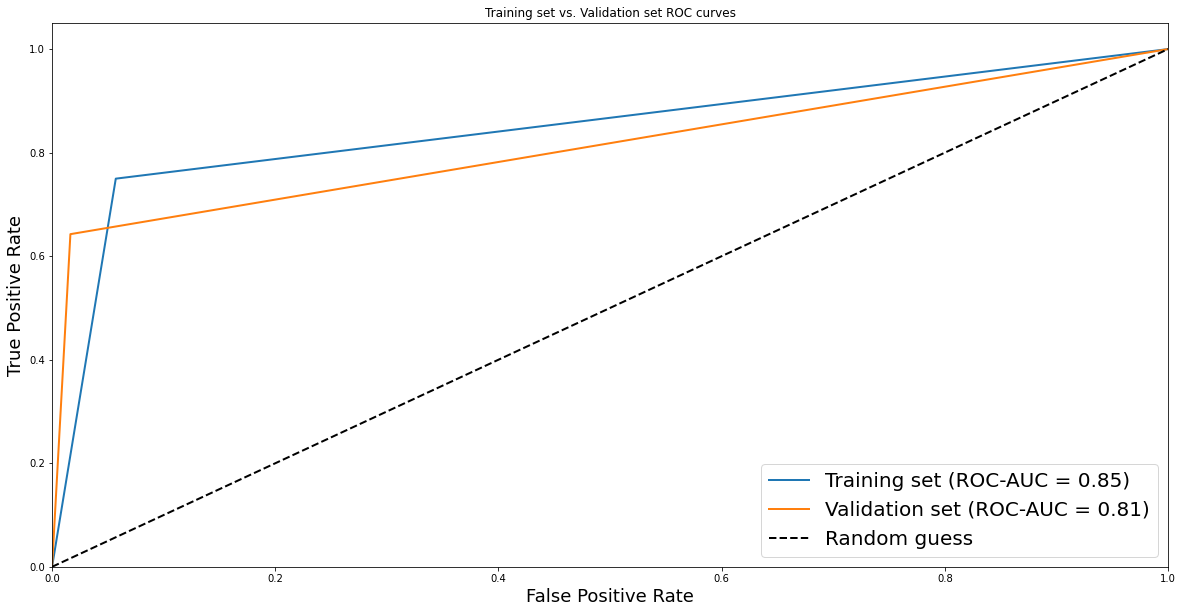

In [176]:
arch_setup.plot_ROC_local_gpu(train_loader,val_loader,model,device)

## Submission:

In [ ]:
from src.features import specto_feat

In [ ]:
test_path = 'MAFAT RADAR Challenge - Public Test Set V1'
test_df = get_data.load_data(PATH_ROOT+PATH_DATA+test_path)
test_df = specto_feat.data_preprocess(test_df.copy())
test_x = test_df['iq_sweep_burst']
test_x = test_x.reshape(list(test_x.shape)+[1])

In [ ]:
# Creating DataFrame with the probability prediction for each segment
submission =  pd.DataFrame()
submission['segment_id'] = test_df['segment_id']
submission['prediction'] = model(torch.from_numpy(test_x.squeeze()).type(torch.FloatTensor)).detach().numpy()
submission['prediction'] = submission['prediction'].astype('float')

# Save submission
submission.to_csv('submission.csv', index=False)

### NO MANDS LAND

In [25]:
dummy = np.random.rand(64,126,32)
dummy = torch.from_numpy(dummy).to(device,dtype=torch.float32)

In [26]:
model = tcn_model2.TemporalConvNet(1,num_channels=[32,1], kernel_size=3, dropout=0.2)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), betas=(0.9, 0.999), lr=1e-4, weight_decay=0)

In [27]:
y_hat = model(dummy)

In [28]:
y_hat

tensor([[0.4837],
        [0.4805],
        [0.4212],
        [0.4866],
        [0.3841],
        [0.4699],
        [0.4656],
        [0.4825],
        [0.5212],
        [0.5032],
        [0.4936],
        [0.5210],
        [0.5122],
        [0.4088],
        [0.4249],
        [0.4931],
        [0.4387],
        [0.4319],
        [0.4234],
        [0.5035],
        [0.4766],
        [0.4939],
        [0.4831],
        [0.5082],
        [0.5182],
        [0.4425],
        [0.4233],
        [0.4301],
        [0.4561],
        [0.4644],
        [0.5010],
        [0.4759],
        [0.4411],
        [0.5096],
        [0.5057],
        [0.4433],
        [0.4974],
        [0.4348],
        [0.4760],
        [0.5012],
        [0.4587],
        [0.4760],
        [0.4830],
        [0.4650],
        [0.4374],
        [0.5215],
        [0.4740],
        [0.5101],
        [0.4593],
        [0.4478],
        [0.4065],
        [0.4012],
        [0.3653],
        [0.5244],
        [0.4627],
        [0

In [42]:
def get_ndarray(embedding_values):
    results = []
    for row in embedding_values:
        arr = np.array(row)
        results.append(
            np.pad(arr, ((10 - arr.shape[0], 0), (0, 0)), 'constant')
        )
    # shape: (examples, emb_dim, seq_length)
    return np.transpose(np.stack(results), (0, 2, 1))

In [44]:
get_ndarray(df_train['audio_embedding']).shape

(1195, 128, 10)